<h1><center>Spotifind</center></h1>

<center>Using Spotify API and Scikit to generate music recommendations based on a given playlist.<center>

Import Dependancies + Setup Data

In [1]:
import re
import ast
import spotipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
# My EDM playlist
playlist_link = 'https://open.spotify.com/playlist/4b9TJsSBi5xSb56YEj75rx?si=9604233d9fa7458f'

In [3]:
df = pd.read_csv('data/tracks_features.csv')
artists_df = pd.read_csv('data/artists.csv')
# Add your Spotify API details here
SPOTIFY_API_CLIENT_ID = ""
SPOTIFY_API_CLIENT_SECRET = ""

pd.set_option('display.max_columns', None)

Making these columns will help us later.

In [4]:
def add_columns(df):
    df['duration_min'] = df['duration_ms'] / 60000
    df['year'] = df['year'].astype(int)
    df['decade'] = (df['year'] // 10) * 10

In [5]:
add_columns(df)

Let's visualize our music data.

In [6]:
def visualize(df):
    features = ['danceability', 'energy', 'loudness', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                'duration_min']

    categorical_features = ['key', 'mode', 'time_signature', 'decade']

    fig, axs = plt.subplots(1, len(categorical_features), figsize=(20, 4))

    for ax, feature in zip(axs, categorical_features):
        df[feature].value_counts().sort_index().plot(
            kind='bar', title=f'{feature} distribution', ax=ax)
        ax.set_xlabel(feature)
        ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(2, 5, figsize=(20, 8))

    for ax, feature in zip(axs.flatten(), features):
        ax.hist(df[feature], bins=100)
        ax.set_title(f'Histogram of {feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

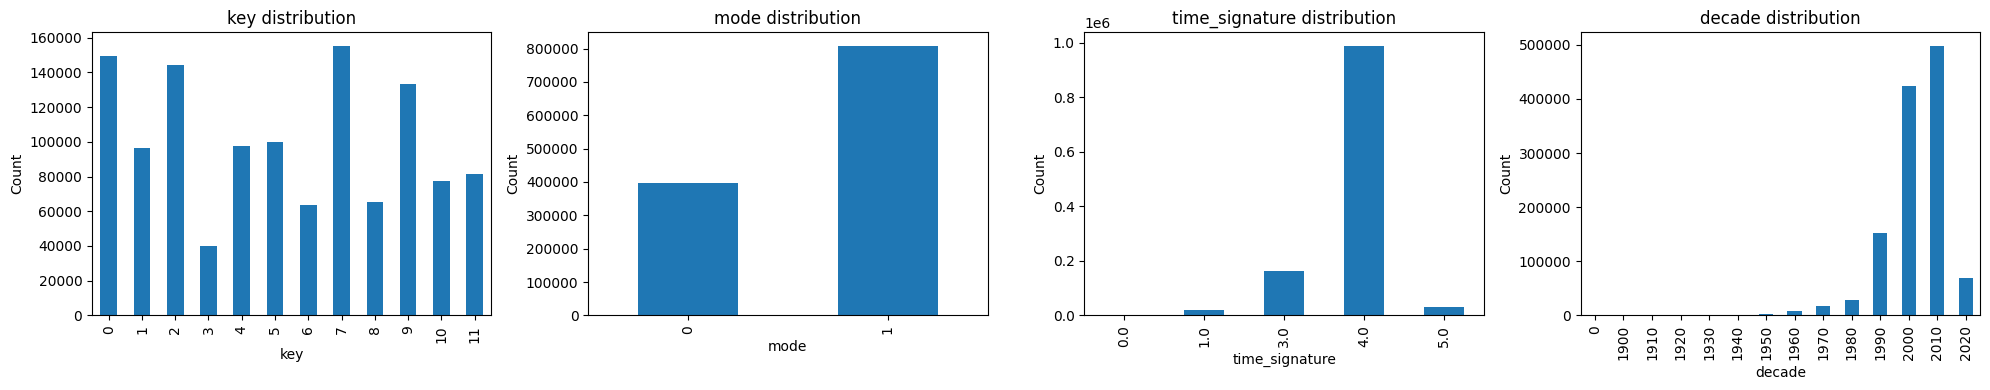

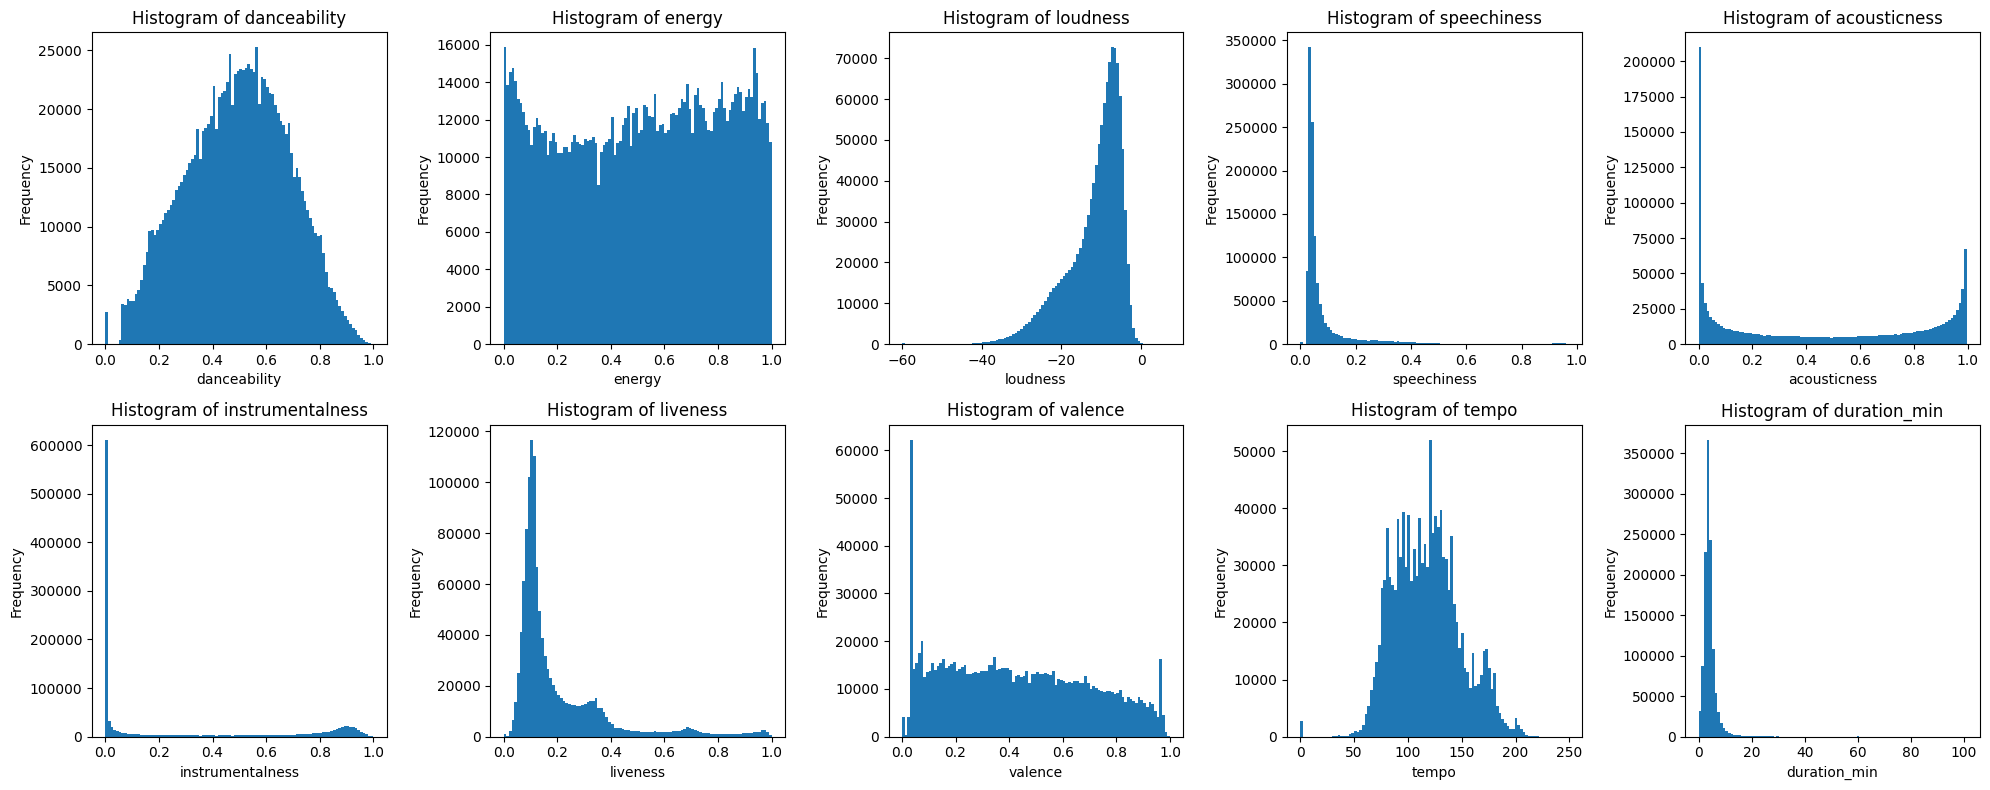

In [7]:
visualize(df)

The 'lists' that we are given may just be strings in disguise -- so let's make them into actual lists and make sure the rest of our data have the right types.

In [8]:
def string_to_list(s):
    if isinstance(s, str):
        return ast.literal_eval(s)
    elif isinstance(s, list):
        return s
    else:
        return []

df['artists'] = df['artists'].apply(string_to_list)
df['artist_ids'] = df['artist_ids'].apply(string_to_list)
df['time_signature'] = df['time_signature'].astype(int)

str_cols = ['id', 'name', 'album', 'album_id']

for col in str_cols:
    df[col] = df[col].astype(str)

artists_df['genres'] = artists_df['genres'].apply(string_to_list)

Since the dataset doesn't have genre/popularity information for each song, we initialized the `artists_df` dataframe to give songs genres and popularity scores based on their respective artist(s).

In [9]:
# Create a dictionary of artist ID-genres + ID-popularity mapping
artist_genres_map = artists_df.set_index('id')['genres'].to_dict()
artist_popularity_map = artists_df.set_index('id')['popularity'].to_dict()

# Function to retrieve genres/popularity for an artist ID
def get_genres_for_artist_df(artist_id):
    return artist_genres_map.get(artist_id, [])

def get_popularity_for_artist_df(artist_id):
    return artist_popularity_map.get(artist_id, 0)

# Apply the function to populate the 'genres'/'popularity' column
df['genres'] = df['artist_ids'].apply(
    lambda ids: [genre for id in ids for genre in get_genres_for_artist_df(id)]
)
df['popularity'] = df['artist_ids'].apply(
    lambda ids: np.mean([get_popularity_for_artist_df(id) for id in ids])
)

<h2><center>Connecting to Spotify API</center></h2>

In [10]:
client_credentials_manager = SpotifyClientCredentials(
    client_id=SPOTIFY_API_CLIENT_ID, client_secret=SPOTIFY_API_CLIENT_SECRET)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Now, use a public spotify playlist's URL to fetch its details.

In [11]:
def fetch_playlist_details(playlist_url):
    # Extract the playlist ID from the URL
    playlist_id = re.search(
        'https://open.spotify.com/playlist/([^?]*)', playlist_url).group(1)

    # Fetch the playlist details
    playlist = sp.playlist(playlist_id)

    # Get the total number of tracks in the playlist
    total_tracks = playlist['tracks']['total']

    # Data storage
    data = []

    # Fetch tracks in batches of 100
    offset = 0
    batch_size = 100

    while offset < total_tracks:
        # Fetch a batch of tracks
        results = sp.playlist_tracks(
            playlist_id, offset=offset, limit=batch_size)

        # Get the tracks in the batch
        tracks = results['items']

        for i, item in enumerate(tracks):
            track = item['track']

            if track is None or track['id'] is None:
                continue

            # Fetch audio features for the track
            audio_features = sp.audio_features(track['id'])[0]

            # Prepare the track data
            track_data = {
                'id': track['id'],
                'name': track['name'],
                'album': track['album']['name'],
                'album_id': track['album']['id'],
                'artists': [artist['name'] for artist in track['artists']],
                'artist_ids': [artist['id'] for artist in track['artists']],
                'track_number': track['track_number'],
                'disc_number': track['disc_number'],
                'explicit': track['explicit'],
                'release_date': track['album']['release_date'],
                # Assume that the year is the first 4 characters of the release date
                'year': track['album']['release_date'][:4]
            }

            # Combine track details and audio features
            track_data.update(audio_features)

            # Add the track data to the data storage
            if track['name'] and track['artists'] != []:
                data.append(track_data)

        # Increment the offset to fetch the next batch
        offset += batch_size

    # Convert the data storage into a DataFrame
    df = pd.DataFrame(data)

    # Return the DataFrame
    return df

In [12]:
playlist_df = fetch_playlist_details(playlist_link)

In [13]:
playlist_df

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,release_date,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,6fKEplI9iN0JMHsRGQESaT,Firebird,Pharmacy,4QcXq4vTVN7dFb7bZa9jG2,[Galantis],[4sTQVOfp9vEMCemLw50sbu],10,1,False,2015-06-05,2015,0.547,0.878,3,-4.245,1,0.0485,0.001450,0.344000,0.3360,0.405,128.018,audio_features,spotify:track:6fKEplI9iN0JMHsRGQESaT,https://api.spotify.com/v1/tracks/6fKEplI9iN0J...,https://api.spotify.com/v1/audio-analysis/6fKE...,248280,4
1,2FiSTH0GYpIioUgjfzMIja,Stay (feat. Maty Noyes),Cloud Nine,0uMIzWh1uEpHEBell4rlF8,"[Kygo, Maty Noyes]","[23fqKkggKUBHNkbKtXEls4, 5JSXWmQO8csVUy6hSRu8TA]",11,1,False,2016-05-13,2016,0.648,0.736,8,-7.948,1,0.0385,0.044400,0.000137,0.1710,0.378,103.027,audio_features,spotify:track:2FiSTH0GYpIioUgjfzMIja,https://api.spotify.com/v1/tracks/2FiSTH0GYpIi...,https://api.spotify.com/v1/audio-analysis/2FiS...,239465,4
2,5PX4uS1LqlWEPL69phPVQQ,Pursuit Of Happiness - Extended Steve Aoki Remix,Pursuit Of Happiness [Extended Steve Aoki Remi...,38MFjDPIDJFfLF7IVpe1rv,"[Kid Cudi, MGMT, Ratatat, Steve Aoki]","[0fA0VVWsXO9YnASrzqfmYu, 0SwO7SWeDHJijQ3XNS7xE...",1,1,True,2012-01-01,2012,0.722,0.687,0,-5.189,1,0.0556,0.009490,0.004130,0.0462,0.619,128.013,audio_features,spotify:track:5PX4uS1LqlWEPL69phPVQQ,https://api.spotify.com/v1/tracks/5PX4uS1LqlWE...,https://api.spotify.com/v1/audio-analysis/5PX4...,373627,4
3,0bAEQpV9IJQ5on41dWvyLd,Now Or Never - Original Mix,Tritonia - Chapter 001,5MUvLEG2znA3JSRfUQ2czS,"[Tritonal, Phoebe Ryan]","[521qvhdobR0GzhvU6TFw76, 4N874uPqBka1QiCvnCVOtr]",1,1,False,2014-04-21,2014,0.528,0.848,6,-4.242,0,0.0600,0.034100,0.021700,0.2840,0.235,127.975,audio_features,spotify:track:0bAEQpV9IJQ5on41dWvyLd,https://api.spotify.com/v1/tracks/0bAEQpV9IJQ5...,https://api.spotify.com/v1/audio-analysis/0bAE...,275594,4
4,5jnp8E61wcoF6qIEtDHQnJ,All We Need,In Return,5SXT6dwhHX56Sos7KMcMF5,"[ODESZA, Shy Girls]","[21mKp7DqtSNHhCAU2ugvUw, 4oFdxup3UmMDNoLLITyDrs]",4,1,False,2014-09-08,2014,0.644,0.848,4,-4.952,0,0.0511,0.004160,0.016800,0.0629,0.283,99.989,audio_features,spotify:track:5jnp8E61wcoF6qIEtDHQnJ,https://api.spotify.com/v1/tracks/5jnp8E61wcoF...,https://api.spotify.com/v1/audio-analysis/5jnp...,211200,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,42ZwelVk9yQF4Twt9l43Ba,Feeling Stronger - High Maintenance Remix,Get Crazy / Feeling Stronger (The Remixes),5YvvsKpSClP5pGTDuEclSz,"[MUZZ, Charlotte Colley, High Maintenance]","[4UNnRb4LN2hGtbtMfPzMhg, 6AahY7rodF2tNZlKD348p...",3,1,False,2015-06-29,2015,0.434,0.950,5,-2.996,0,0.0383,0.000455,0.012800,0.4310,0.532,174.960,audio_features,spotify:track:42ZwelVk9yQF4Twt9l43Ba,https://api.spotify.com/v1/tracks/42ZwelVk9yQF...,https://api.spotify.com/v1/audio-analysis/42Zw...,252215,4
242,0NIC4unbe5KZOp1d9T7OaF,Secrets,"Club Life, Vol. 4 - New York City",57bABnvvPfNhBQRI70dqlU,"[Tiësto, KSHMR, VASSY]","[2o5jDhtHVPhrJdv3cEQ99Z, 2wX6xSig4Rig5kZU6ePlW...",2,1,False,2015-05-18,2015,0.648,0.812,11,-7.585,0,0.0414,0.000329,0.036900,0.0857,0.122,128.178,audio_features,spotify:track:0NIC4unbe5KZOp1d9T7OaF,https://api.spotify.com/v1/tracks/0NIC4unbe5KZ...,https://api.spotify.com/v1/audio-analysis/0NIC...,250947,4
243,3sl4dcqSwxHVnLfqwF2jly,Hello (feat. Dragonette),Hello,1Jbwq1BswM8apm7pjRZKq8,"[Martin Solveig, Dragonette]","[1bj5GrcLom5gZFF5t949Xl, 4GLJPBj5Cdr9AgLKvLWM4n]",1,1,False,2010-12-14,2010,0.666,0.975,3,-3.470,1,0.0345,0.013500,0.000925,0.1050,0.452,128.005,audio_features,spotify:track:3sl4dcqSwxHVnLfqwF2jly,https://api.spotify.com/v1/tracks/3sl4dcqSwxHV...,https://api.spotify.com/v1/audio-analysis/3sl4...,191388,4
244,7JN9mnz4OPVivc9AF0FLAJ,Tether (Eric Prydz Vs. CHVRCHES) - Radio Edit,Tether (Eric Prydz Vs. CHVRCHES) [Radio Edit],0l4PrdzOh4l88cDGbzznBP,"[Eric Prydz, CHVRCHES]","[5sm0jQ1mq0dusiLtDJ2b4R, 3Cj

Add genre/popularity information to the `playlist_df` dataframe by getting genre and popularity via Spotify API.

In [14]:
def get_genres_for_artist(artist_id):
    artist = sp.artist(artist_id)
    return artist['genres']

def get_popularity_for_artist(artist_id):
    artist = sp.artist(artist_id)
    return artist['popularity']

playlist_df['genres'] = playlist_df['artist_ids'].apply(
    lambda ids: [genre for id in ids for genre in get_genres_for_artist(id)]
)

playlist_df['popularity'] = playlist_df['artist_ids'].apply(
    lambda ids: np.mean([get_popularity_for_artist(id) for id in ids])
)


Clean the `playlist_df` dataframe and visualize it.

In [15]:
playlist_df = playlist_df.drop(
    columns=['type', 'uri', 'track_href', 'analysis_url'])
add_columns(playlist_df)

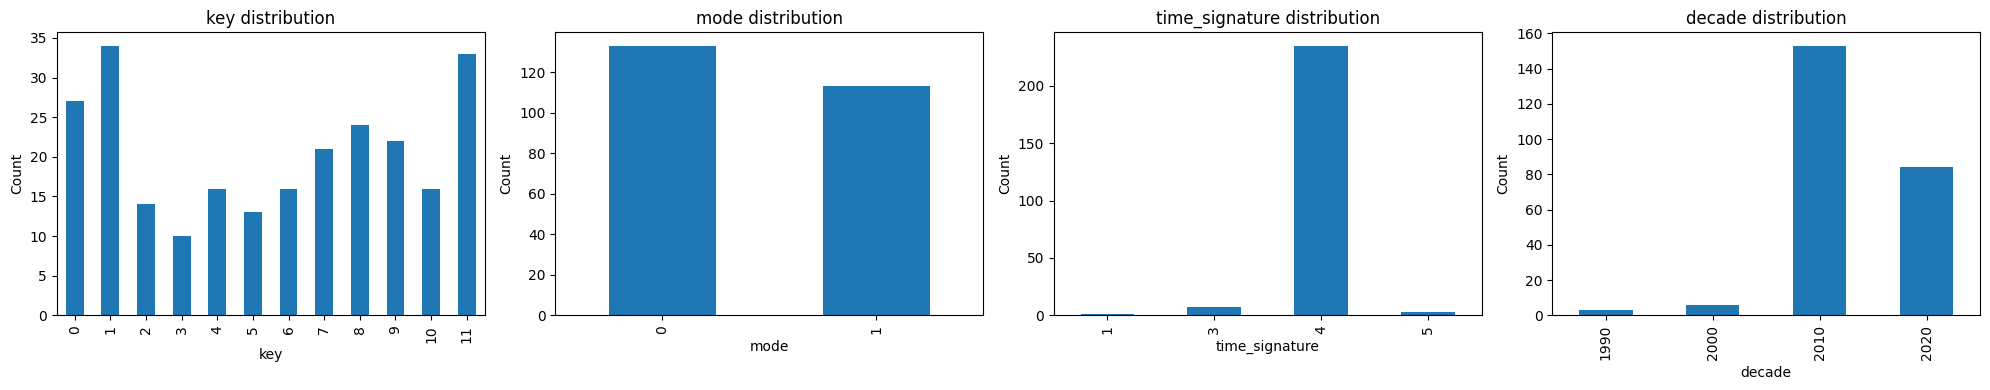

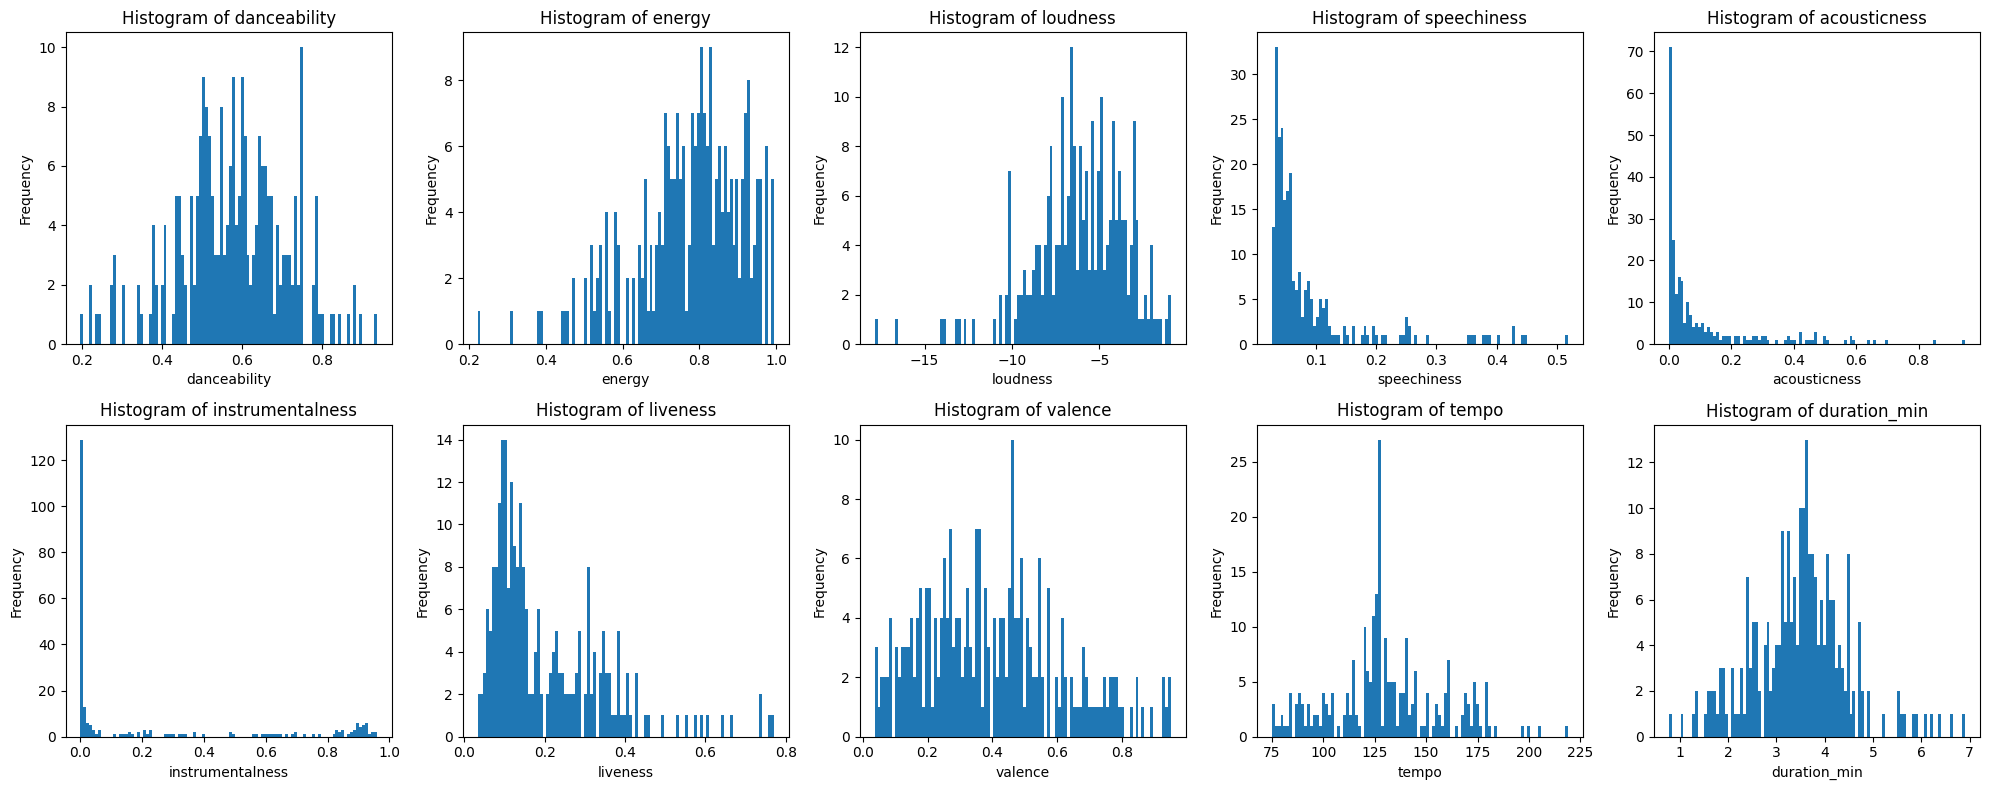

In [16]:
visualize(playlist_df)

<h2><center>Building a Song Recommender</center><h2>



Make sure the data looks right. Let's use `.head()` to do this.

In [17]:
df.head()

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date,duration_min,decade,genres,popularity
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,[Rage Against The Machine],[2d0hyoQ5ynDBnkvAbJKORj],1,1,False,0.470,0.978,7,-5.399,1,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4,1999,1999-11-02,3.502217,1990,"[alternative metal, alternative rock, consciou...",75.0
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,[Rage Against The Machine],[2d0hyoQ5ynDBnkvAbJKORj],2,1,True,0.599,0.957,11,-5.764,1,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4,1999,1999-11-02,3.436667,1990,"[alternative metal, alternative rock, consciou...",75.0
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,[Rage Against The Machine],[2d0hyoQ5ynDBnkvAbJKORj],3,1,False,0.315,0.970,7,-5.424,1,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4,1999,1999-11-02,4.981550,1990,"[alternative metal, alternative rock, consciou...",75.0
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,[Rage Against The Machine],[2d0hyoQ5ynDBnkvAbJKORj],4,1,True,0.440,0.967,11,-5.830,0,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4,1999,1999-11-02,3.560667,1990,"[alternative metal, alternative rock, consciou...",75.0
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,[Rage Against The Machine],[2d0hyoQ5ynDBnkvAbJKORj],5,1,False,0.426,0.929,2,-6.729,1,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4,1999,1999-11-02,3.426667,1990,"[alternative metal, alternative rock, consciou...",75.0


In [18]:
playlist_df.head()

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,release_date,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genres,popularity,duration_min,decade
0,6fKEplI9iN0JMHsRGQESaT,Firebird,Pharmacy,4QcXq4vTVN7dFb7bZa9jG2,[Galantis],[4sTQVOfp9vEMCemLw50sbu],10,1,False,2015-06-05,2015,0.547,0.878,3,-4.245,1,0.0485,0.00145,0.344000,0.3360,0.405,128.018,248280,4,"[dance pop, edm, pop, pop dance]",72.00,4.138000,2010
1,2FiSTH0GYpIioUgjfzMIja,Stay (feat. Maty Noyes),Cloud Nine,0uMIzWh1uEpHEBell4rlF8,"[Kygo, Maty Noyes]","[23fqKkggKUBHNkbKtXEls4, 5JSXWmQO8csVUy6hSRu8TA]",11,1,False,2016-05-13,2016,0.648,0.736,8,-7.948,1,0.0385,0.04440,0.000137,0.1710,0.378,103.027,239465,4,"[edm, pop, pop dance, tropical house, alt z]",65.50,3.991083,2010
2,5PX4uS1LqlWEPL69phPVQQ,Pursuit Of Happiness - Extended Steve Aoki Remix,Pursuit Of Happiness [Extended Steve Aoki Remi...,38MFjDPIDJFfLF7IVpe1rv,"[Kid Cudi, MGMT, Ratatat, Steve Aoki]","[0fA0VVWsXO9YnASrzqfmYu, 0SwO7SWeDHJijQ3XNS7xE...",1,1,True,2012-01-01,2012,0.722,0.687,0,-5.189,1,0.0556,0.00949,0.004130,0.0462,0.619,128.013,373627,4,"[hip hop, ohio hip hop, pop rap, rap, alternat...",72.75,6.227117,2010
3,0bAEQpV9IJQ5on41dWvyLd,Now Or Never - Original Mix,Tritonia - Chapter 001,5MUvLEG2znA3JSRfUQ2czS,"[Tritonal, Phoebe Ryan]","[521qvhdobR0GzhvU6TFw76, 4N874uPqBka1QiCvnCVOtr]",1,1,False,2014-04-21,2014,0.528,0.848,6,-4.242,0,0.0600,0.03410,0.021700,0.2840,0.235,127.975,275594,4,"[edm, electro house, pop dance, pop edm, progr...",54.00,4.593233,2010
4,5jnp8E61wcoF6qIEtDHQnJ,All We Need,In Return,5SXT6dwhHX56Sos7KMcMF5,"[ODESZA, Shy Girls]","[21mKp7DqtSNHhCAU2ugvUw, 4oFdxup3UmMDNoLLITyDrs]",4,1,False,2014-09-08,2014,0.644,0.848,4,-4.952,0,0.0511,0.00416,0.016800,0.0629,0.283,99.989,211200,4,"[chillwave, edm, indietronica, portland hip ho...",57.50,3.520000,2010


Normalize float variables.

In [19]:
float_cols = df.dtypes[df.dtypes == 'float64'].index.values
float_cols = float_cols[float_cols != 'popularity']
float_cols

array(['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_min'], dtype=object)

One hot encode `popularity` (and soon `year`). OHE refers to the technique with which categorical data is represented as numerical values for ML models.

In [20]:
ohe_cols = 'popularity'
df['popularity'].describe()

count    1.204025e+06
mean     2.759096e+01
std      2.350606e+01
min      0.000000e+00
25%      3.500000e+00
50%      2.500000e+01
75%      4.600000e+01
max      9.800000e+01
Name: popularity, dtype: float64

In [21]:
playlist_df['popularity'].describe()

count    246.000000
mean      56.859756
std       15.236601
min        0.000000
25%       46.000000
50%       59.000000
75%       68.000000
max       88.000000
Name: popularity, dtype: float64

Let's score popularity by 5 point buckets.

In [22]:
# create 5 point buckets for popularity
df['popularity_red'] = df['popularity'].apply(
    lambda x: int(x/5))

playlist_df['popularity_red'] = playlist_df['popularity'].apply(
    lambda x: int(x/5))

And reorder the playlist dataframe's columns so that we can add them to the main dataframe. If songs in our playlist aren't in the original dataset, we can now append them so that they will be part of our feature set.

In [23]:
column_names = ['id', 'name', 'album', 'album_id', 'artists', 'artist_ids', 'track_number', 'disc_number', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'year', 'release_date', 'duration_min', 'decade', 'genres', 'popularity', 'popularity_red']

playlist_df = playlist_df[column_names]

In [24]:
df = pd.concat([df, playlist_df], ignore_index=True)

Feature Set Function

In [26]:
def create_feature_set(df, float_cols):
    """
    Process main df to create a final set of features that will be used to generate recommendations.
    Parameters:
        df (pandas dataframe): Main Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
    Returns:
        final: final set of features 
    """
    # tfidf genre lists
    tfidf = TfidfVectorizer()
    genre_matrix = tfidf.fit_transform(df['genres'].apply(" ".join))

    # One-Hot Encoding (ohe) year and popularity
    year_ohe = pd.get_dummies(df['year'], prefix='year').values * 0.5
    popularity_ohe = pd.get_dummies(
        df['popularity_red'], prefix='pop').values * 0.15

    # scale float columns
    scaler = MinMaxScaler()
    floats_scaled = scaler.fit_transform(df[float_cols]) * 0.2

    # concatenate all features
    final_features = hstack([genre_matrix, csr_matrix(
        floats_scaled), csr_matrix(popularity_ohe), csr_matrix(year_ohe)])

    # Create DataFrame from sparse matrix
    final_df = pd.DataFrame.sparse.from_spmatrix(final_features)

    # add song id
    final_df['id'] = df['id'].values

    return final_df

Make the feature set for the newly combined dataframe.

In [27]:
fset = create_feature_set(df, float_cols)
fset

0    1    2    3    4    5    6    7    8    9   10   11   12   13  \
0        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1204266  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1204267  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1204268  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1204269  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1204270  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

          14   15   16   17   18   19   20   21   22   23   24   25   26   27  \
0        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1204266  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1204267  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1204268  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1204269  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1204270  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

          28   29   30   31   32   33   34   35   36   37   38   39   40   41  \
0        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1204266  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1204267  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1204268  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1204269  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1204270  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

          42   43   44   45   46   47   48   49   50   51   52   53   54  \
0        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1204266  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1204267  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1204268  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1204269  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1204270  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

               55   56   57   58   59   60   61   62   63   64   65   66   67  \
0        0.287594  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1        0.287594

Make sure our playlist songs are all available in the dataset.

In [28]:
def create_necessary_outputs(playlist_id, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_id (str): ID of the playlist you'd like to pull from the Spotify API
        df (pandas dataframe): spotify dataframe
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE DATASET (Should be all of them)
    """

    # Generate playlist dataframe
    playlist = pd.DataFrame()

    for ix, i in enumerate(sp.playlist(playlist_id)['tracks']['items']):
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])

    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values(
        'date_added', ascending=False)

    return playlist

In [29]:
playlist_id = re.search(
    'https://open.spotify.com/playlist/([^?]*)', playlist_link).group(1)
my_playlist = create_necessary_outputs(playlist_id, df)

In [30]:
my_playlist

,artist,name,id,date_added
99,Aurosonic,You'll Be Fine,5yXE9kKaAMc8093lnDimbj,2022-03-23 02:37:24+00:00
98,San Holo,Light,6jq6rcOikCZAmjliAgAmfT,2022-02-13 08:09:42+00:00
97,Zedd,Clarity,60wwxj6Dd9NJlirf84wr2c,2022-02-09 13:41:32+00:00
96,Porter Robinson,Something Comforting,5g7bsxCqNaucnXpexUoHg8,2022-02-01 21:48:28+00:00
95,Kygo,This Town (feat. Sasha Alex Sloan),4aSfgWmRa9KsISD4Jmx7QB,2022-01-19 17:25:31+00:00
...,...,...,...,...
4,ODESZA,All We Need,5jnp8E61wcoF6qIEtDHQnJ,2020-09-23 07:02:54+00:00
3,Tritonal,Now Or Never - Original Mix,0bAEQpV9IJQ5on41dWvyLd,2020-09-23 07:00:45+00:00
2,Kid Cudi,Pursuit Of Happiness - Extended Steve Aoki Remix,5PX4uS1LqlWEPL69phPVQQ,2020-09-23 06:58:26+00:00
1,Kygo,Stay (feat. Maty Noyes),2FiSTH0GYpIioUgjfzMIja,2020-09-23 06:40:51+00:00


Create Playlist Vector

In [31]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """

    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(
        playlist_df['id'].values)]  # .drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(
        playlist_df[['id', 'date_added']], on='id', how='inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(
        playlist_df['id'].values)]  # .drop('id', axis = 1)

    playlist_feature_set = complete_feature_set_playlist.sort_values(
        'date_added', ascending=False)

    most_recent_date = playlist_feature_set.iloc[0, -1]

    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix, 'months_from_recent'] = int(
            (most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)

    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(
        lambda x: weight_factor ** (-x))

    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(
        playlist_feature_set_weighted.iloc[:, :-4].mul(playlist_feature_set_weighted.weight, 0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']

    return playlist_feature_set_weighted_final.sum(axis=0), complete_feature_set_nonplaylist

In [32]:
recency_bias_weight = 1.09 # Should be close to 1
num_of_recs = 50

In [33]:
complete_feature_set_playlist_vector, complete_feature_set_nonplaylist = generate_playlist_feature(
    fset, my_playlist, recency_bias_weight)


In [34]:
def generate_playlist_recos(df, features, nonplaylist_features, num):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top: Recommendations for that playlist
    """
    non_playlist_df = df[df['id'].isin(
        nonplaylist_features['id'].values)].copy()
    non_playlist_df.loc[:, 'sim'] = cosine_similarity(nonplaylist_features.drop(
        'id', axis=1).values, features.values.reshape(1, -1))[:, 0]
    non_playlist_df_top = non_playlist_df.sort_values(
        'sim', ascending=False).head(num)

    return non_playlist_df_top


In [35]:
recs = generate_playlist_recos(
    df, complete_feature_set_playlist_vector, complete_feature_set_nonplaylist, num_of_recs)

In [36]:
recs

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date,duration_min,decade,genres,popularity,popularity_red,sim
881388,1ftzZWaKP6ny1bmQI6aZJV,Shed a Light - MOTi Remix,Shed a Light (The Remixes Part 1),58OE2rEc7U2G5Nx4LBFj9V,"[Robin Schulz, David Guetta, Cheat Codes, MOTi]","[3t5xRXzsuZmMDkQzgOX35S, 1Cs0zKBU1kc0i8ypK3B9a...",2,1,False,0.664,0.800,1,-6.916,1,0.0406,0.004970,0.028500,0.3060,0.610,122.021,271475,4,2017,2017-02-10,4.524583,2010,"[dance pop, deep euro house, deep house, edm, ...",80.750000,16,0.824125
1168920,4WdX6MM8nZSRrc7BX9yQUY,When You're Alone (feat. Kiesza),Letters To Remember,5ewnC9DmcClqT2cqKvvNCe,"[Lucas & Steve, Kiesza]","[5wwneIFdawNgQ7GvKK29Z3, 4zxvC7CRGvggq9EWXOpwAo]",7,1,False,0.701,0.869,9,-5.263,1,0.0429,0.026200,0.002960,0.0798,0.847,122.025,179511,4,2020,2020-10-16,2.991850,2020,"[dance pop, edm, electro house, pop dance, pop...",67.500000,13,0.822444
753462,6M1Wwaq7XizO4T5OAHXNlQ,Oceans Away - Sam Feldt Remix,Oceans Away (The Remixes),3690nbTudIa2mLmExkD3zy,"[A R I Z O N A, Sam Feldt]","[7hOGhpa8RMSuDOWntGIAJt, 20gsENnposVs2I4rQ5kvrf]",1,1,False,0.741,0.613,1,-9.347,1,0.0354,0.316000,0.031600,0.0893,0.271,115.031,171109,4,2017,2017-02-24,2.851817,2010,"[electropop, indie poptimism, pop, pop dance, ...",74.000000,14,0.821043
1148762,408G7co3LC8uM5pMTldO4X,Scared to Be Lonely - Loud Luxury Remix,Scared To Be Lonely Remixes Vol. 2,5jTkDSrXEBAowWeHpsA1a2,"[Martin Garrix, Dua Lipa, Loud Luxury]","[60d24wfXkVzDSfLS6hyCjZ, 6M2wZ9GZgrQXHCFfjv46w...",3,1,False,0.731,0.670,1,-6.780,0,0.0487,0.017200,0.001010,0.1710,0.290,127.076,207885,4,2017,2017-03-24,3.464750,2010,"[dance pop, dutch edm, edm, electro house, pop...",84.333333,16,0.820723
1185760,0e0UxWGgjXoYAYUFhJgwji,Feel Good,Awake,5rvIgXvAPGWspXY4rDLkeU,"[ILLENIUM, Gryffin, Daya]","[45eNHdiiabvmbp4erw26rg, 2ZRQcIgzPCVaT9XKhXZIz...",11,1,False,0.625,0.707,2,-4.761,1,0.0337,0.220000,0.000000,0.2130,0.479,138.064,248156,4,2017,2017-09-21,4.135933,2010,"[edm, electropop, melodic dubstep, pop, pop da...",52.000000,10,0.820195
1035885,7vfVE2NzjFs3WBglCA5o8Y,Slow (feat. Noah Cyrus) - R3HAB Remix,Slow (feat. Noah Cyrus) [R3HAB Remix],2cad4FTVUJIRRlPTJcaWpr,"[Matoma, Noah Cyrus, R3HAB]","[4YXycRbyyAE0wozTk7QMEq, 55fhWPvDiMpLnE4ZzNXZy...",1,1,False,0.544,0.817,6,-4.477,1,0.0794,0.139000,0.000000,0.1120,0.464,140.026,160286,4,2017,2017-12-22,2.671433,2010,"[dance pop, edm, electro house, electropop, no...",78.000000,15,0.816565
881393,4CiS1MAheYESOEoknLAOt9,Shed a Light - MDZN Remix,Shed a Light (The Remixes Part 2),65h91TpH6k56OdninmMeov,"[Robin Schulz, David Guetta, Cheat Codes, MDZN]","[3t5xRXzsuZmMDkQzgOX35S, 1Cs0zKBU1kc0i8ypK3B9a...",1,1,False,0.611,0.954,5,-4.187,0,0.0341,0.014000,0.000525,0.1560,0.464,137.968,207118,4,2017,2017-02-24,3.451967,2010,"[dance pop, deep euro house, deep house, edm, ...",63.000000,12,0.816184
881395,244iTkmcMTNcPuwPHNuX1m,Shed a Light - Heyder Remix,Shed a Light (The Remixes Part 2),65h91TpH6k56OdninmMeov,"[Robin Schulz, David Guetta, Cheat Codes, Heyder]","[3t5xRXzsuZmMDkQzgOX35S, 1Cs0zKBU1kc0i8ypK3B9a...",3,1,False,0.566,0.917,5,-3.715,0,0.0910,0.007370,0.000000,0.1700,0.616,125.908,219072,4,2017,2017-02-24,3.651200,2010,"[dance pop, deep euro house, deep house, edm, ...",63.000000,12,0.815336
618691,5CYYljiI0WgstAMtsTALSw,Honest - SAVI Remix,Honest (Remixes),07cmevY2Te9mLWpoXVECbI,"[The Chainsmokers, Savi]","[69GGBxA162lTqCwzJG5jLp, 1H72fTOUAUl0WQ4kH5DPVW]",4,1,False,0.656,0.722,0,-6.146,0,0.0664,0.050300,0.000175,0.1310,0.663,100.000,207080,4,2017,2017-08-04,3.451333,2010,"[dance pop, edm, electropop, pop, pop dance, t...",61.000000,12,0.814671
1148754,7ayQbUum7VTA22ORil79M0,Scared To Be Lonely - Julien Earle Remix,Scared To Be Lonely Remixes Vol. 1,5dwSRV6U5oyxplujp17RQQ,"[Martin Garrix, Dua Lipa, Julien Earle]","[60d24wfXkVzDSfLS6hyCjZ, 6M2wZ9GZgrQXHCFfj